## NOTE

add in metrics  
lr  
activation funtion (tanh)  

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

In [3]:
print(tf.__version__)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

1.15.2


In [4]:
df = pd.read_csv('../../eICU/training/finalData.csv')
df

,patientunitstayid,observationoffset,temperature,heartrate,respiration,systemicsystolic,creatinine,wbcx1000,lactate,urineoutputbyweight,diagnosis
0,141227,-1893.0,38.03651,112.0,49.0,158.00000,1.40,48.20,4.300000,2.433090,0
1,141227,-1773.0,38.03651,112.0,49.0,158.00000,1.40,48.20,4.300000,2.433090,0
2,141227,-1663.0,38.03651,112.0,49.0,158.00000,1.40,48.20,4.300000,2.433090,0
3,141227,-1566.0,38.03651,112.0,49.0,158.00000,1.40,48.20,4.300000,2.433090,0
4,141227,-1351.0,38.03651,112.0,49.0,158.00000,1.40,47.95,4.300000,2.433090,0
...,...,...,...,...,...,...,...,...,...,...,...
6042126,3353254,5326.0,38.03651,82.0,12.0,118.56613,1.65,11.32,2.655717,4.767580,0
6042127,3353254,5491.0,38.03651,82.0,12.0,118.56613,1.66,11.51,2.655717,2.383790,0
6042128,3353254,5558.0,38.03651,82.0,12.0,118.56613,1.67,11.70,2.655717,4.767580,0
6042129,3353254,5926.0,38.03651,82.0,12.0,118.56613,1.67,11.70,2.655717,7.151371,0


In [5]:
df = df.astype({'diagnosis': int})
df['diagnosis'].value_counts()

0    6025670
1      16461
Name: diagnosis, dtype: int64

In [6]:
len(df['patientunitstayid'].unique())

18271

In [7]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

4833704 1208427


# Preprocessing

In [8]:
from sklearn.preprocessing import RobustScaler

f_columns = ['patientunitstayid','observationoffset','temperature', 'heartrate', 'respiration', 'systemicsystolic', 'creatinine', 'wbcx1000', 'lactate', 'urineoutputbyweight']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['observationoffset']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['observationoffset'] = cnt_transformer.transform(train[['observationoffset']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['observationoffset'] = cnt_transformer.transform(test[['observationoffset']])

/home/sanjay/.local/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.observationoffset, time_steps)
X_test, y_test = create_dataset(test, test.observationoffset, time_steps)

print(X_train.shape, y_train.shape)

(4833694, 10, 11) (4833694,)


In [13]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=256, 
    validation_split=0.2,
    shuffle=False
)

Train on 3866955 samples, validate on 966739 samples
Epoch 1/100
3866955/3866955 [==============================] - 254s 66us/sample - loss: 0.0053 - val_loss: 3.8944e-05
Epoch 2/100
3866955/3866955 [==============================] - 255s 66us/sample - loss: 2.7191e-04 - val_loss: 1.1013e-05
Epoch 3/100
3866955/3866955 [==============================] - 252s 65us/sample - loss: 3.6550e-04 - val_loss: 1.8472e-05
Epoch 4/100
3866955/3866955 [==============================] - 254s 66us/sample - loss: 3.3748e-04 - val_loss: 3.2694e-05
Epoch 5/100
3866955/3866955 [==============================] - 255s 66us/sample - loss: 1.1532e-04 - val_loss: 6.8292e-06
Epoch 6/100
3866955/3866955 [==============================] - 258s 67us/sample - loss: 8.3768e-05 - val_loss: 7.0150e-06
Epoch 7/100
3866955/3866955 [==============================] - 256s 66us/sample - loss: 1.8375e-04 - val_loss: 1.0301e-05
Epoch 8/100
3866955/3866955 [==============================] - 254s 66us/sample - loss: 6.4070e-0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3866955/3866955 [==============================] - 260s 67us/sample - loss: 7.0427e-05 - val_loss: 2.8522e-04
Epoch 92/100
2376448/3866955 [=================>............] - ETA: 1:31 - loss: 4.7028e-05

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3866955/3866955 [==============================] - 259s 67us/sample - loss: 1.4372e-05 - val_loss: 6.1109e-06
Epoch 95/100
3866955/3866955 [==============================] - 253s 65us/sample - loss: 3.1216e-05 - val_loss: 9.2757e-06
Epoch 96/100
3866955/3866955 [==============================] - 254s 66us/sample - loss: 2.6497e-05 - val_loss: 4.7368e-06
Epoch 97/100
3866955/3866955 [==============================] - 255s 66us/sample - loss: 1.8704e-05 - val_loss: 7.1244e-05
Epoch 98/100
3866955/3866955 [==============================] - 253s 65us/sample - loss: 4.3721e-05 - val_loss: 3.9518e-06
Epoch 99/100
3866955/3866955 [==============================] - 261s 67us/sample - loss: 7.7915e-05 - val_loss: 2.0229e-06
Epoch 100/100
3866955/3866955 [==============================] - 261s 68us/sample - loss: 8.1438e-05 - val_loss: 2.8329e-04


In [15]:
model.save('m1_checkpoint')

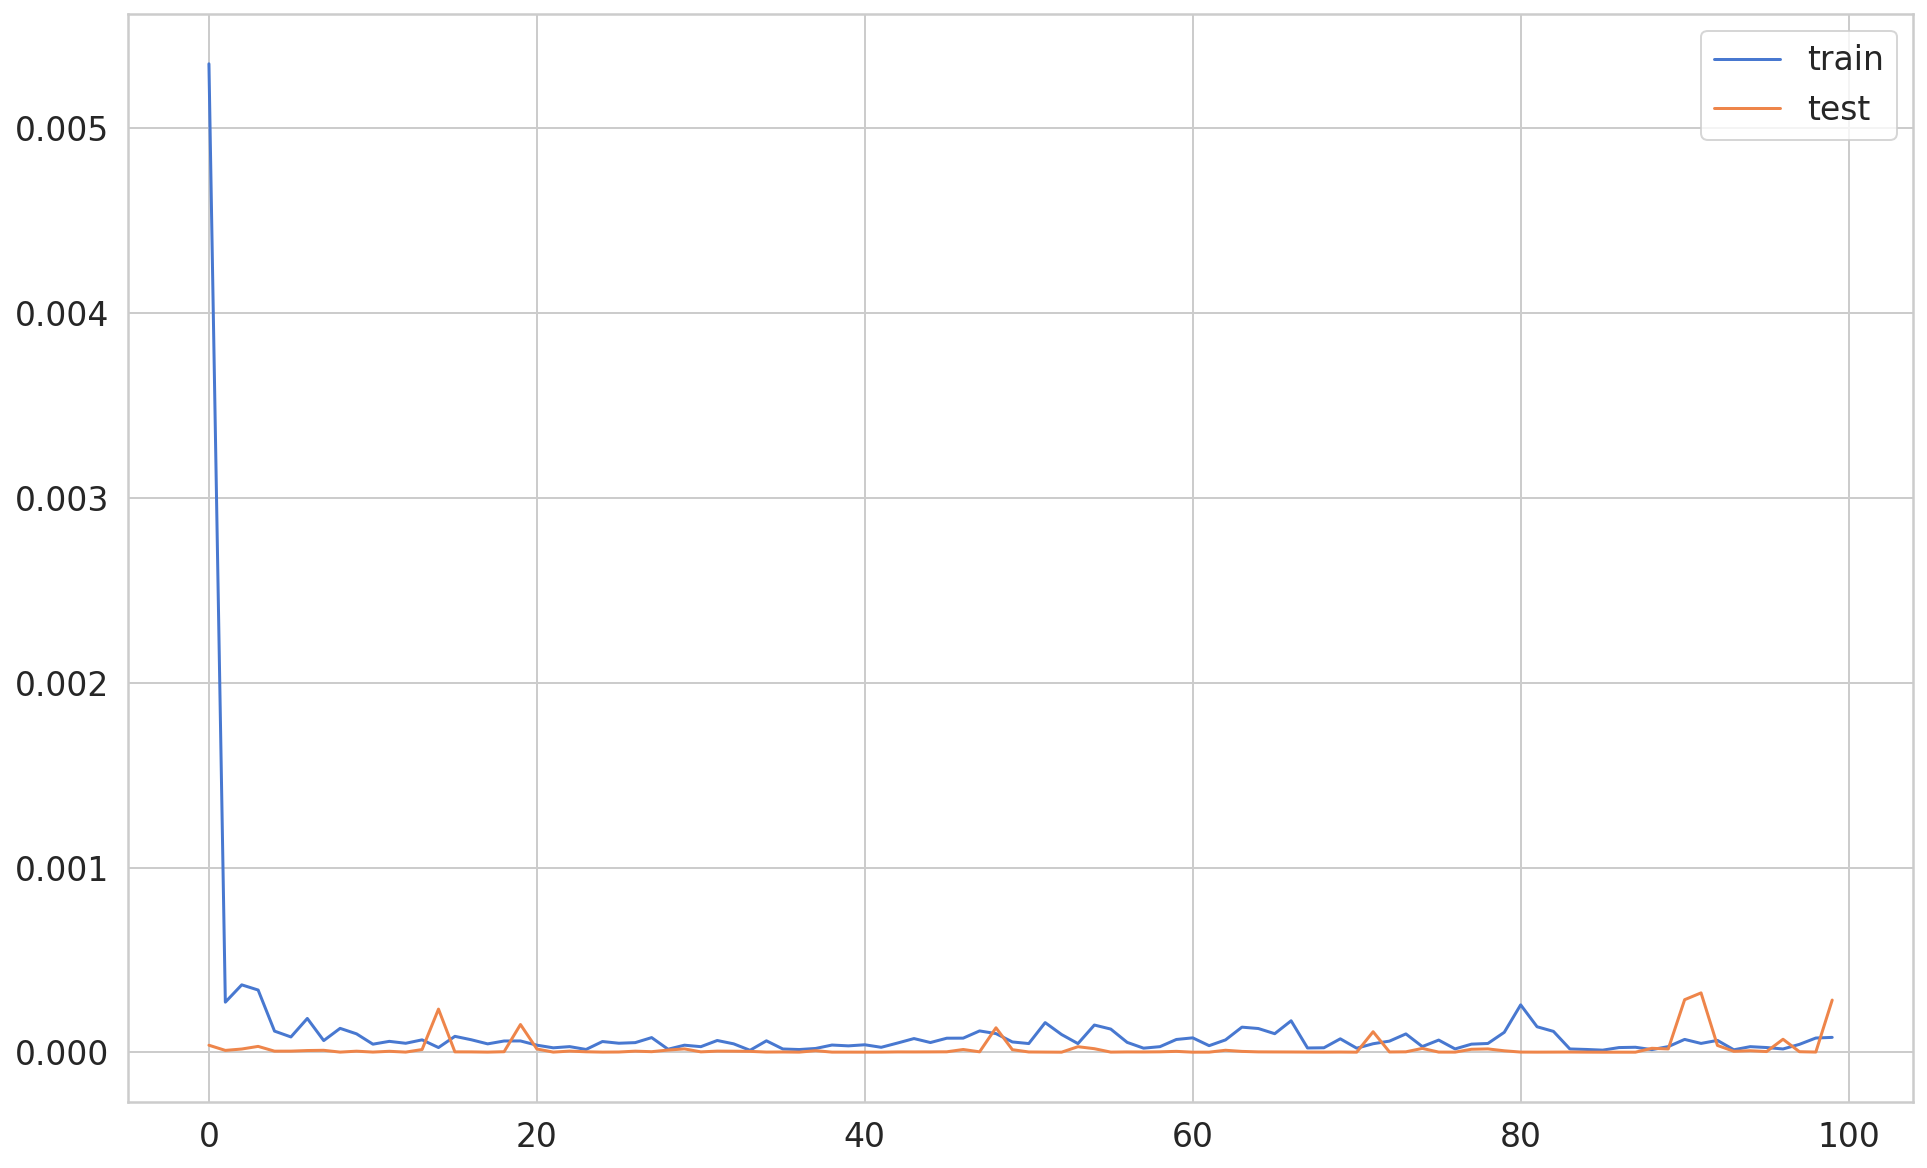

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [17]:
y_pred = model.predict(X_test)

In [18]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

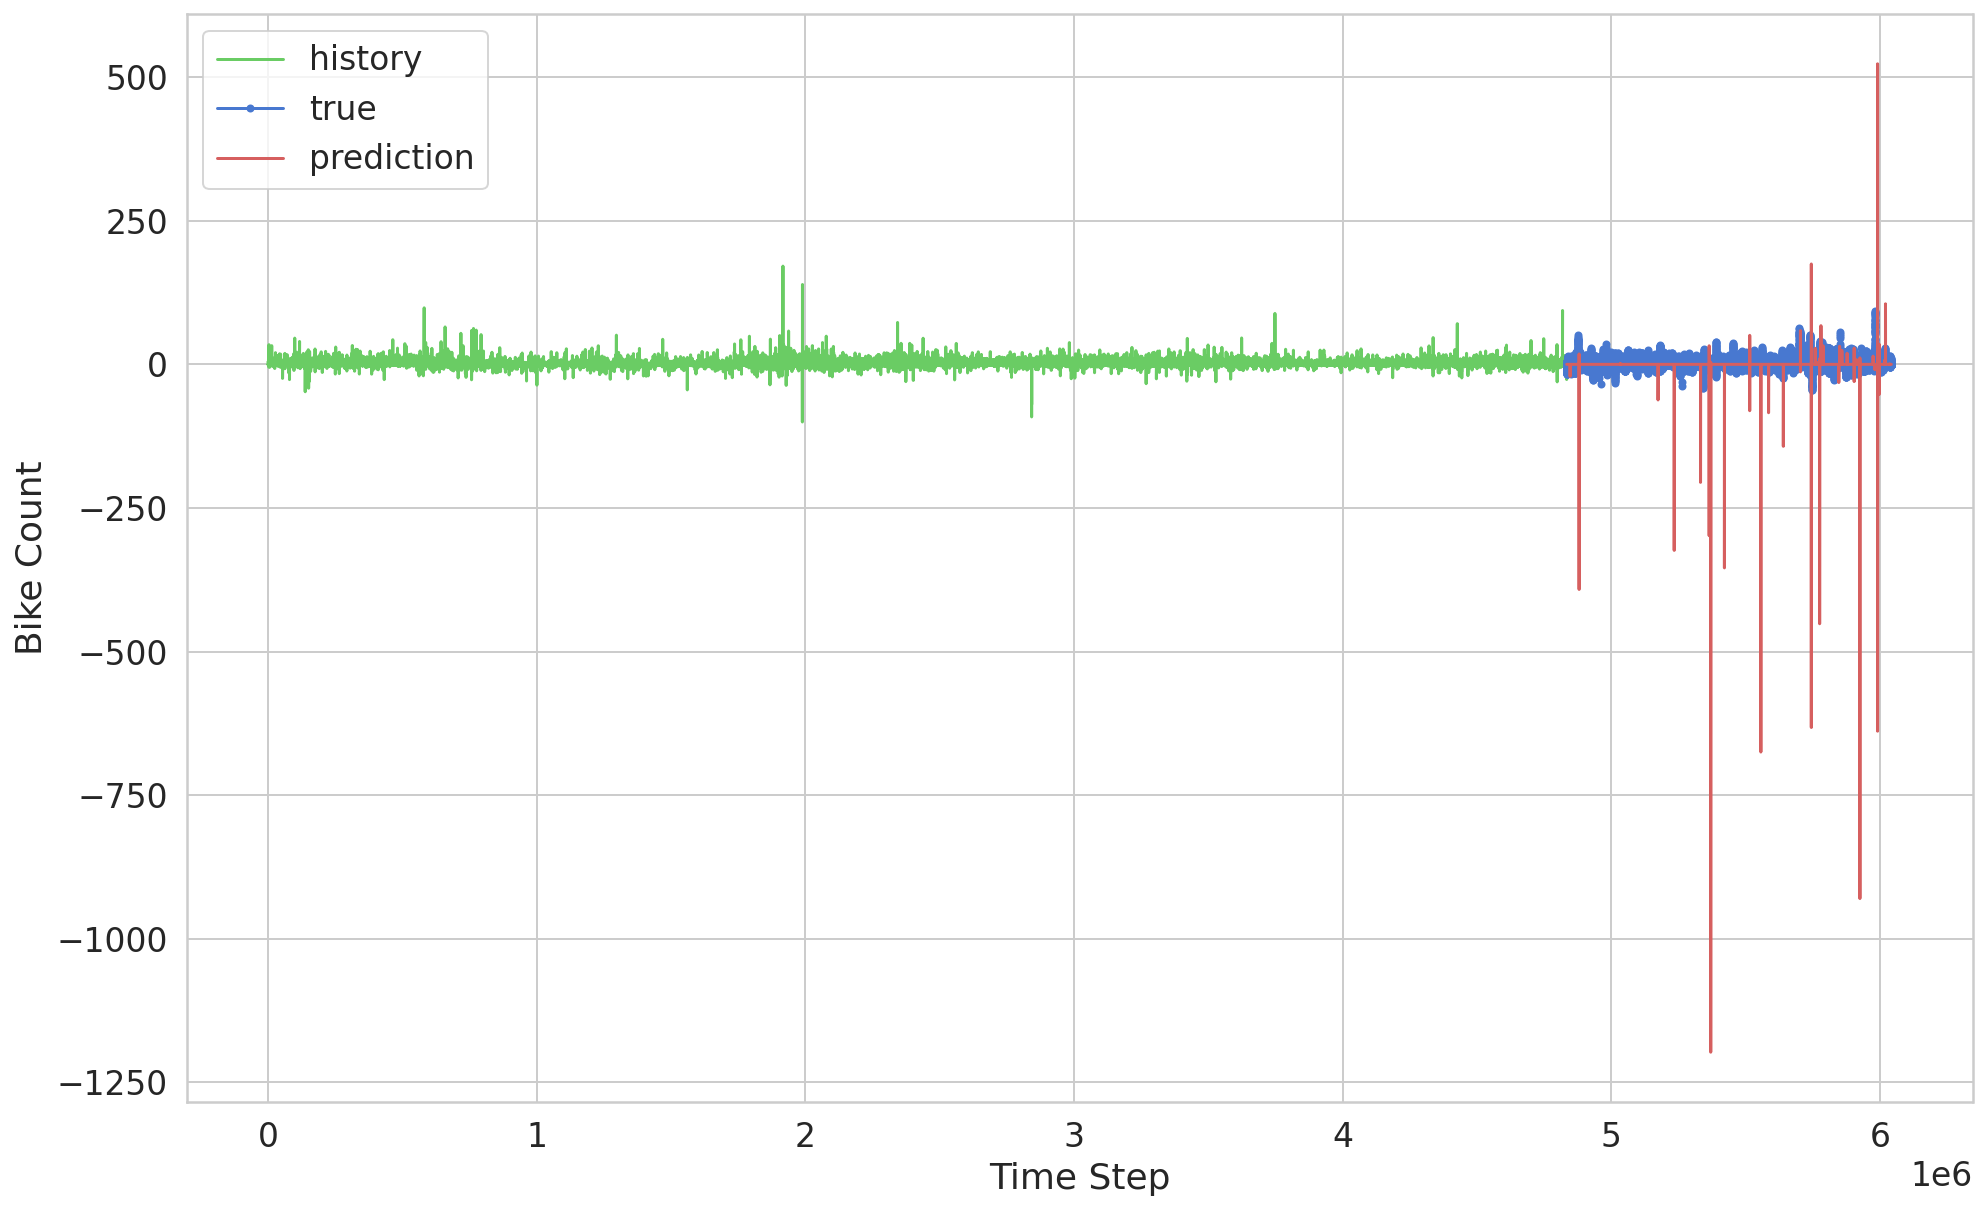

In [19]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

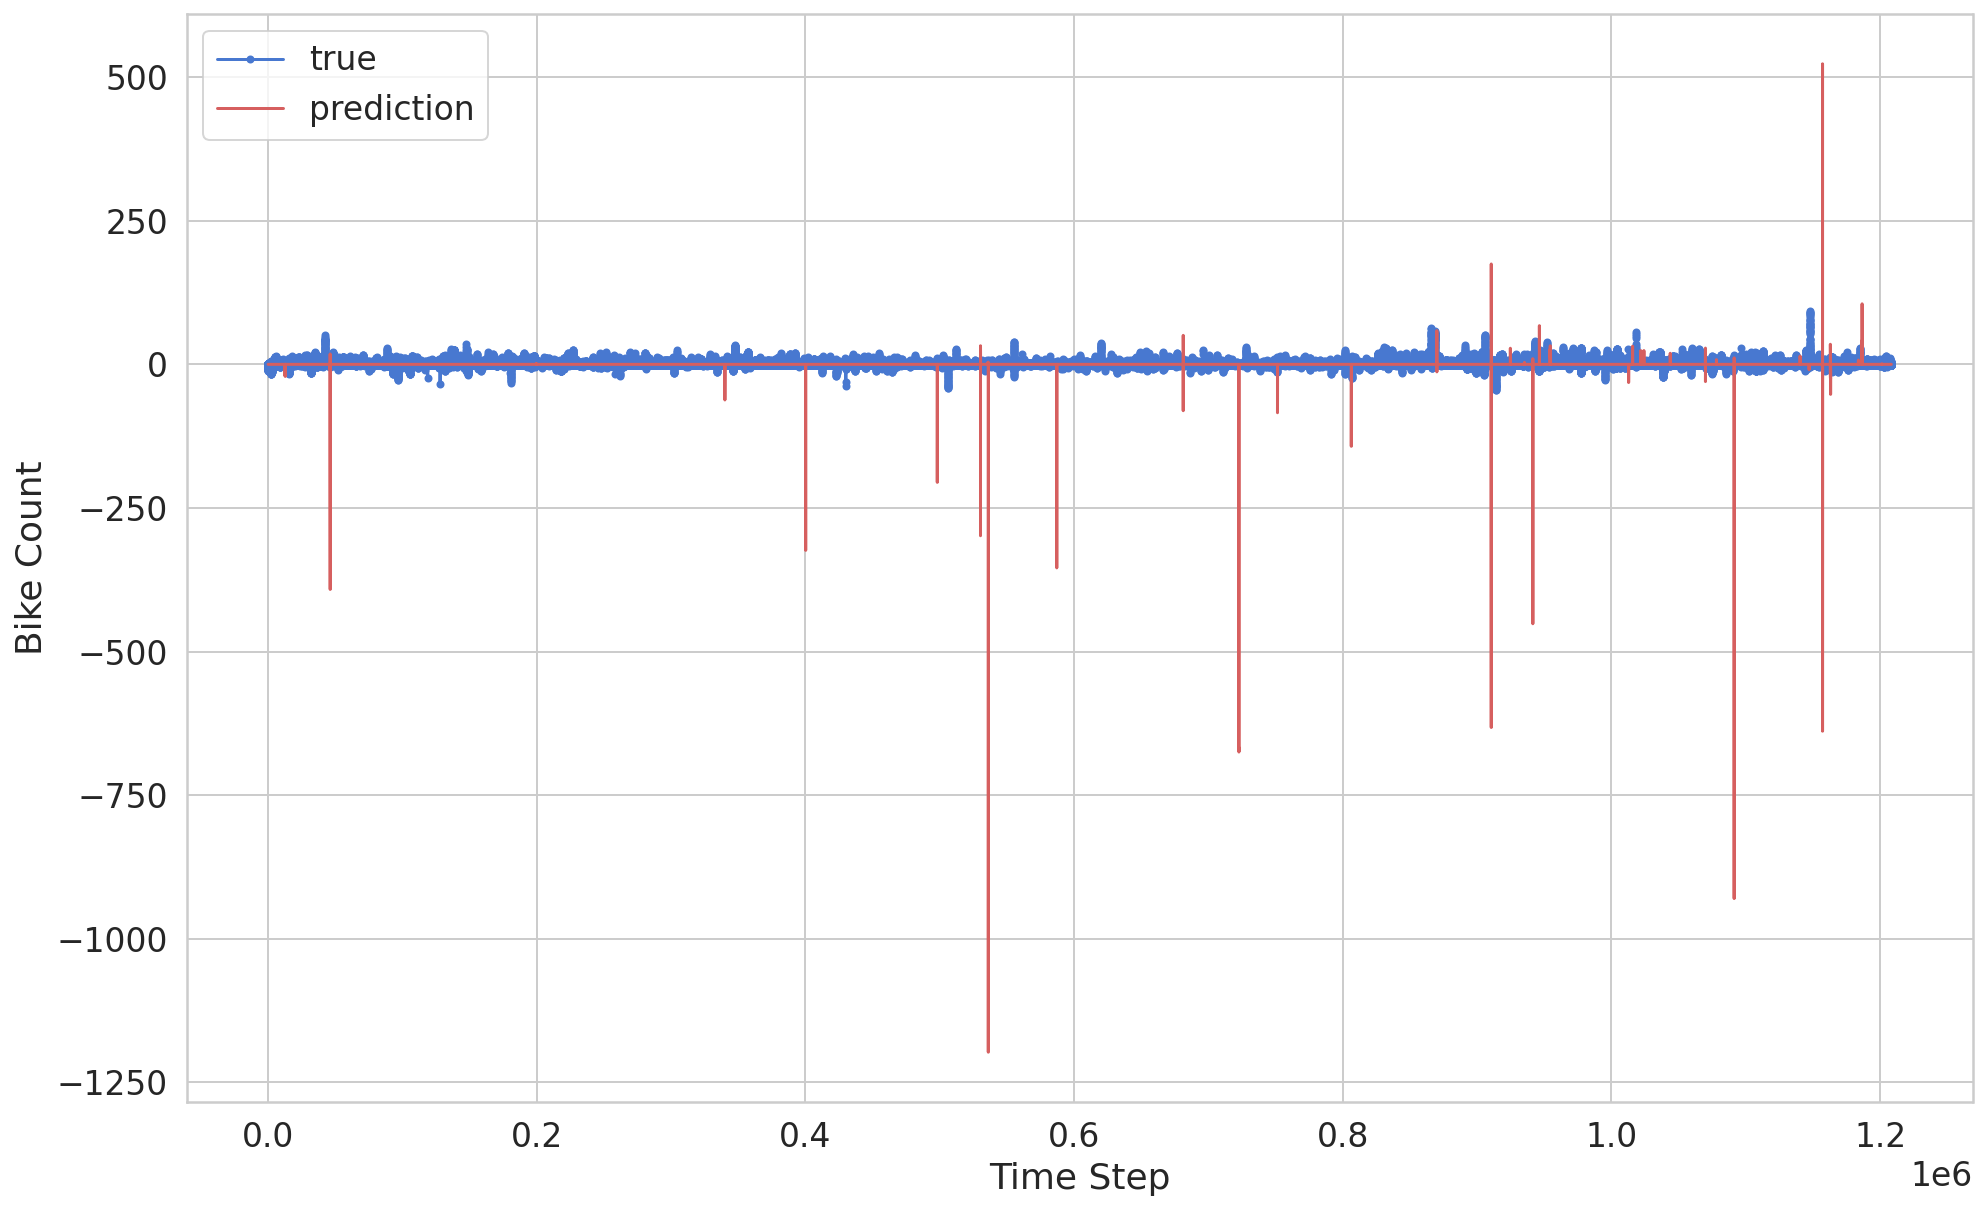

In [20]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
df

In [21]:
results = model.evaluate(X_test, y_test, batch_size=256)

1208417/1208417 [==============================] - 22s 18us/sample - loss: 4.5853e-05


In [34]:
results

4.585298385136954e-05

In [24]:
import pickle

In [30]:
np.save('m1_history.npy',history.history)


In [31]:
history_c =np.load('m1_history.npy',allow_pickle='TRUE').item()

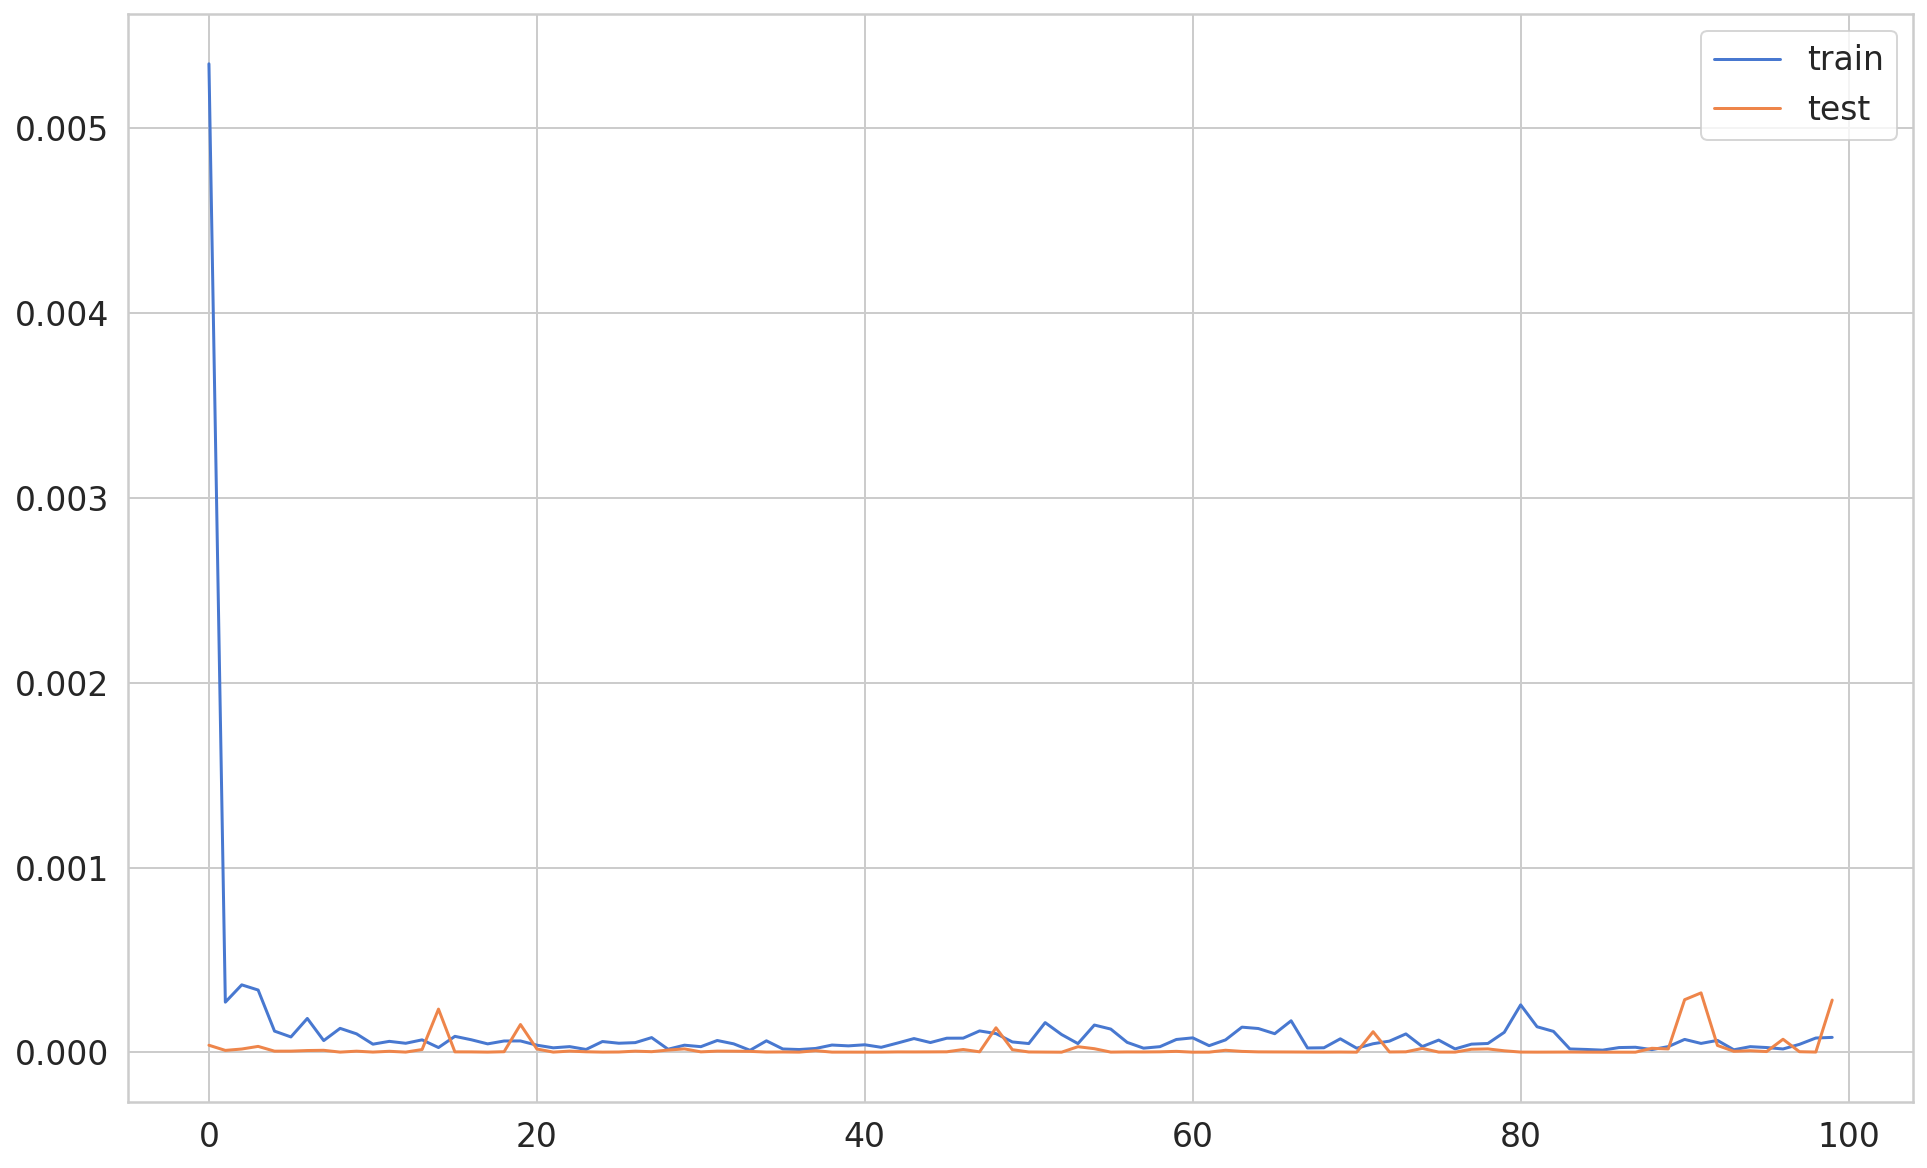

In [32]:
plt.plot(history_c['loss'], label='train')
plt.plot(history_c['val_loss'], label='test')
plt.legend();